In [ ]:
%matplotlib notebook
from skmultiflow.data import WaveformGenerator
from skmultiflow.trees import HoeffdingTree,LCHT
from skmultiflow.evaluation import EvaluatePrequential
# 1. Create a stream
stream = WaveformGenerator()
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
ht = HoeffdingTree()
# 3. Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=2000,
                                max_samples=200000)
# 4. Run evaluation
evaluator.evaluate(stream=stream, model=ht)

In [ ]:
from skmultiflow.trees import HoeffdingTree
tree = HoeffdingTree()

In [65]:
import pickle
import pandas as pd
import numpy as np
data = pickle.load(open('../../affect-recognition/data/processed_data (1).p','rb'))
data = data[data.user.isin(['072c81f7-4410-4301-8fd0-17337c0ac1e8'])].sort_values('time').reset_index(drop=True)

In [66]:
X = np.array([np.array(a) for a in data['X'].values])
y = np.array([np.array(a) for a in data['y'].values])
groups = np.array(list(data['user']))
import pandas as pd
import numpy as np
from skmultiflow.data.base_stream import Stream


class DataStream(Stream):
    """ Creates a stream from a data source.

    DataStream takes the whole data set containing the `X` (features) and `Y` (targets) or takes `X` and `Y` separately.
    For the first case `target_idx` and `n_targets` need to be provided, in the second case they are not needed.

    Parameters
    ----------
    data: np.ndarray or pd.DataFrame (Default=None)
        The features' columns and targets' columns or the feature columns
        only if they are passed separately.
    y: np.ndarray or pd.DataFrame, optional (Default=None)
        The targets' columns.

    target_idx: int, optional (default=-1)
        The column index from which the targets start.

    n_targets: int, optional (default=1)
        The number of targets.

    cat_features: list, optional (default=None)
        A list of indices corresponding to the location of categorical features.

    name: str, optional (default=None)
        A string to id the data.

    Notes
    -----
    The stream object provides upon request a number of samples, in a way such that old samples cannot be accessed
    at a later time. This is done to correctly simulate the stream context.

    """

    _CLASSIFICATION = 'classification'
    _REGRESSION = 'regression'
    _Y_is_defined = False

    def __init__(self, data, y=None, target_idx=-1, n_targets=1, cat_features=None, name=None):
        super().__init__()
        self.X = data
        self.y = y
        self.cat_features = cat_features
        self.cat_features_idx = [] if self.cat_features is None else self.cat_features
        self.n_targets = n_targets
        self.target_idx = target_idx
        self.task_type = None
        self.n_classes = 0
        self.data = data
        self._is_ready = False
        self.name = name
        self.__configure()

    def __configure(self):
        if self._Y_is_defined:
            self.y = pd.DataFrame(self.y)
            if self.y.shape[0] != self.data.shape[0]:
                raise ValueError("X and y should have the same number of rows")
            else:
                self.X = pd.DataFrame(self.data)
                self.target_idx = -self.y.shape[1]
                self.n_targets = self.y.shape[1]

    @property
    def y(self):
        """
        Return the targets' columns.

        Returns
        -------
        np.ndarray:
            the targets' columns
        """
        return self._y

    @y.setter
    def y(self, y):
        """
        Sets the targets' columns

        Parameters
        ----------
        y: pd.DataFrame or np.ndarray
            the targets' columns

        """
        if y is not None and not self._Y_is_defined:
            self._Y_is_defined = True
        if not self._Y_is_defined or (isinstance(y, np.ndarray) or isinstance(y, pd.DataFrame)):
            self._y = y
        else:
            raise ValueError("np.ndarray or pd.DataFrame y object expected, and {} was passed".format(type(y)))

    @property
    def X(self):
        """
        Return the features' columns.

        Returns
        -------
        np.ndarray:
            the features' columns
        """
        return self._X

    @X.setter
    def X(self, X):
        """
        Sets the features' columns.

        Parameters
        ----------
        X: pd.DataFrame or np.ndarray
            the features' columns.
        """

        if isinstance(X, np.ndarray) or isinstance(X, pd.DataFrame) or not self._Y_is_defined:
            self._X = X

        else:
            raise ValueError("np.ndarray or pd.DataFrame X object expected, and {} was passed".format(type(X)))

    @property
    def data(self):
        """
        Return the data set used to generate the stream.

        Returns
        -------
        pd.DataFrame:
            Data set.
        """
        return self._data

    @data.setter
    def data(self, data):
        """
        Sets the data set used to generate the stream.

        Parameters
        ----------
        data: DataFrame or np.ndarray
            the data set

        """

        if isinstance(data, pd.DataFrame):
            self._data = data
        elif isinstance(data, np.ndarray):
            self._data = pd.DataFrame(data)
        else:
            raise ValueError("Invalid type {}, for data".format(type(data)))

    @data.deleter
    def data(self):
        """
            Deletes data
        """
        del self._data

    @property
    def target_idx(self):
        """
        Get the number of the column where Y begins.

        Returns
        -------
        int:
            The number of the column where Y begins.
        """
        return self._target_idx

    @target_idx.setter
    def target_idx(self, target_idx):
        """
        Sets the number of the column where Y begins.

        Parameters
        ----------
        target_idx: int
        """

        self._target_idx = target_idx

    @property
    def n_targets(self):
        """
         Get the number of targets.

        Returns
        -------
        int:
            The number of targets.
        """
        return self._n_targets

    @n_targets.setter
    def n_targets(self, n_targets):
        """
        Sets the number of targets.

        Parameters
        ----------
        n_targets: int
        """

        self._n_targets = n_targets

    @property
    def cat_features_idx(self):
        """
        Get the list of the categorical features index.

        Returns
        -------
        list:
            List of categorical features index.

        """
        return self._cat_features_idx

    @cat_features_idx.setter
    def cat_features_idx(self, cat_features_idx):
        """
        Sets the list of the categorical features index.

        Parameters
        ----------
        cat_features_idx:
            List of categorical features index.
        """

        self._cat_features_idx = cat_features_idx

    def prepare_for_use(self):
        """
        Prepares the stream for use.

        Notes
        -----
        This functions should always be called after the stream initialization.

        """
        self.restart()
        if not self._is_ready:
            if self._Y_is_defined:
                self._load_X_y()
            else:
                self._load_data()
                del self.data
            self._is_ready = True

    def _load_X_y(self):

        self.y = pd.DataFrame(self.y)

        self.n_samples, self.n_features = self.X.shape
        self.feature_names = self.X.columns.values.tolist()
        self.target_names = self.y.columns.values.tolist()

        self.y = self.y.values
        self.X = self.X.values

        if self.cat_features_idx:
            if max(self.cat_features_idx) < self.n_features:
                self.n_cat_features = len(self.cat_features_idx)
            else:
                raise IndexError('Categorical feature index in {} '
                                 'exceeds n_features {}'.format(self.cat_features_idx, self.n_features))
        self.n_num_features = self.n_features - self.n_cat_features

        if np.issubdtype(self.y.dtype, np.integer):
            self.task_type = self._CLASSIFICATION
            self.n_classes = len(np.unique(self.y))
        else:
            self.task_type = self._REGRESSION

        self.target_values = self._get_target_values()

    def _load_data(self):

        rows, cols = self.data.shape
        self.n_samples = rows
        labels = self.data.columns.values.tolist()

        if (self.target_idx + self.n_targets) == cols or (self.target_idx + self.n_targets) == 0:
            # Take everything to the right of target_idx
            self.y = self.data.iloc[:, self.target_idx:].values
            self.target_names = self.data.iloc[:, self.target_idx:].columns.values.tolist()
        else:
            # Take only n_targets columns to the right of target_idx, use the rest as features
            self.y = self.data.iloc[:, self.target_idx:self.target_idx + self.n_targets].values
            self.target_names = labels[self.target_idx:self.target_idx + self.n_targets]

        self.X = self.data.drop(self.target_names, axis=1).values
        self.feature_names = self.data.drop(self.target_names, axis=1).columns.values.tolist()

        _, self.n_features = self.X.shape
        if self.cat_features_idx:
            if max(self.cat_features_idx) < self.n_features:
                self.n_cat_features = len(self.cat_features_idx)
            else:
                raise IndexError('Categorical feature index in {} '
                                 'exceeds n_features {}'.format(self.cat_features_idx, self.n_features))
        self.n_num_features = self.n_features - self.n_cat_features

        if np.issubdtype(self.y.dtype, np.integer):
            self.task_type = self._CLASSIFICATION
            self.n_classes = len(np.unique(self.y))
        else:
            self.task_type = self._REGRESSION

        self.target_values = self._get_target_values()

    def restart(self):
        """ restart

        Restarts the stream's sample feeding, while keeping all of its
        parameters.

        It basically server the purpose of reinitializing the stream to
        its initial state.

        """
        self.sample_idx = 0
        self.current_sample_x = None
        self.current_sample_y = None

    def next_sample(self, batch_size=1):
        """ next_sample

        If there is enough instances to supply at least batch_size samples, those
        are returned. If there aren't a tuple of (None, None) is returned.

        Parameters
        ----------
        batch_size: int
            The number of instances to return.

        Returns
        -------
        tuple or tuple list
            Returns the next batch_size instances.
            For general purposes the return can be treated as a numpy.ndarray.

        """
        self.sample_idx += batch_size
        try:
#             print(self.X.shape)
            self.current_sample_x = self.X[(self.sample_idx - batch_size):self.sample_idx, :]
            self.current_sample_y = self.y[(self.sample_idx - batch_size):self.sample_idx, :]
            if self.n_targets < 2:
                self.current_sample_y = self.current_sample_y.flatten()

        except IndexError:
            self.current_sample_x = None
            self.current_sample_y = None
        return self.current_sample_x, self.current_sample_y

    def has_more_samples(self):
        """ Checks if stream has more samples.

        Returns
        -------
        Boolean
            True if stream has more samples.

        """
        return (self.n_samples - self.sample_idx) > 0

    def n_remaining_samples(self):
        """ Returns the estimated number of remaining samples.

        Returns
        -------
        int
            Remaining number of samples.

        """
        return self.n_samples - self.sample_idx

    def print_df(self):
        """
        Prints all the samples in the stream.

        """
        print(self.X)
        print(self.y)

    def get_data_info(self):
        name = self.name + ": " if self.name else ""
        if self.task_type == self._CLASSIFICATION:
            return "{}{} target(s), {} classes".format(name, self.n_targets, self.n_classes)
        elif self.task_type == self._REGRESSION:
            return "{} target(s)".format(name, self.n_targets)

    def _get_target_values(self):
        if self.task_type == 'classification':
            if self.n_targets == 1:
                return np.unique(self.y).tolist()
            else:
                return [np.unique(self.y[:, i]).tolist() for i in range(self.n_targets)]
        elif self.task_type == self._REGRESSION:
            return [float] * self.n_targets

    def get_info(self):
        return 'DataStream(n_targets={}, target_idx={}, cat_features={}, name={})'.\
            format(self.target_idx, self.n_targets, self.cat_features,
                   self.name if not self.name else "'" + self.name + "'")

In [67]:
y[y>1] = 1
# stream = DataStream(data=X,y=y.reshape(-1,1))

In [46]:
stream.prepare_for_use()

<IPython.core.display.Javascript object>


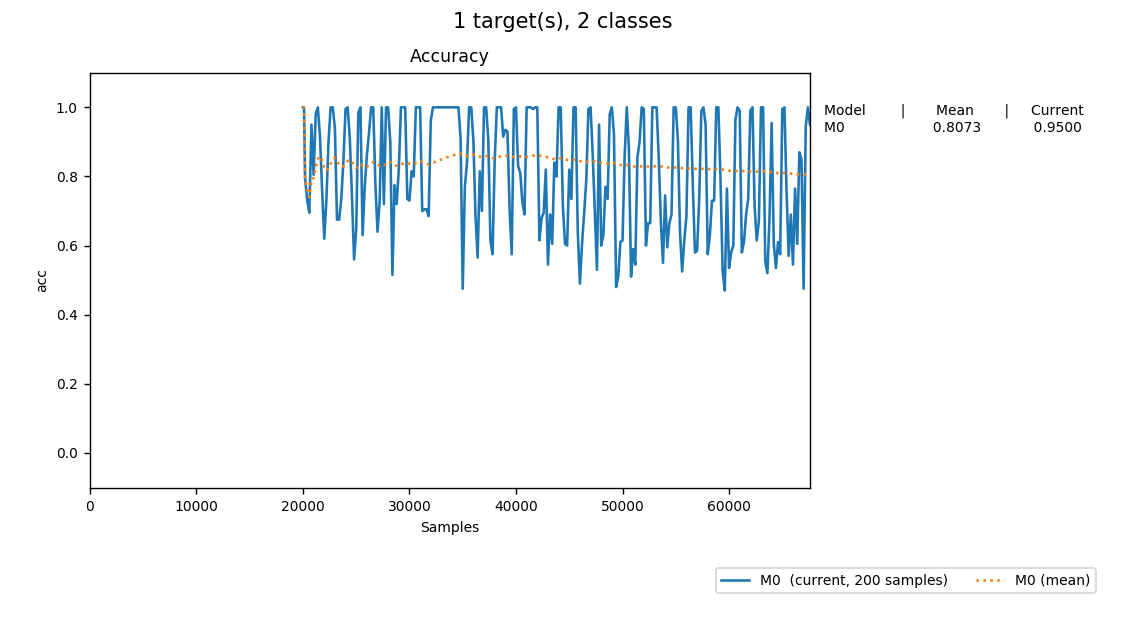

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 20000 sample(s).
Evaluating...
 #################### [100%] [56.21s]
Processed samples: 67715
Mean performance:
M0 - Accuracy     : 0.8073


[HoeffdingTree(binary_split=False, grace_period=200, leaf_prediction='nba',
               max_byte_size=33554432, memory_estimate_period=1000000,
               nb_threshold=0, no_preprune=False, nominal_attributes=None,
               remove_poor_atts=False, split_confidence=1e-07,
               split_criterion='info_gain', stop_mem_management=False,
               tie_threshold=0.05)]

In [61]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation import EvaluatePrequential
ht = HoeffdingTree()
%matplotlib notebook
# 3. Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=20000,
                               metrics=['accuracy'])
# 4. Run evaluation
evaluator.evaluate(stream=stream, model=ht)

In [38]:
from collections import Counter

In [60]:
evaluator.reset

TypeError: 'ConfusionMatrix' object is not callable

In [52]:
1 - 12059/y.shape[0]

0.8219153806394447

In [62]:
X.shape

(67715, 110)

In [63]:
y.shape

(67715,)

In [69]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)


def fit_model(X,y,groups,k,paramGrid):
    X = np.delete(X,k,axis=1)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    return np.array([a,k]).reshape(-1)

def get_results_backward_elimination(X,y,groups):
    
    
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [100,10,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3]],
                 'rf__probability':[True]
    }
    feature_names = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lf-hf']
#     gg = fit_model(deepcopy(X),y,groups,k,paramGrid)
    data = []
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    data.append(['all',a])
    print(data)
    while len(feature_names)>1:
        results = Parallel(n_jobs=30,verbose=4)(delayed(fit_model)(deepcopy(X),y,groups,k,paramGrid) for k,name in enumerate(feature_names))
        results = np.array(results)
        print(results,results.shape)
        ind_min = np.argmax(results[:,0])
        min_f1 = results[ind_min,0]
        min_index = np.int64(results[ind_min,1])
        name_feature = feature_names[min_index]
        data.append([name_feature,min_f1])
        X = np.delete(X,min_index,axis=1)
        feature_names = feature_names[:min_index] + feature_names[(min_index+1):]
        print(data)
    return data
    
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__C': [10,1,100,200],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', LogisticRegression())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred))
    clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
    clf.fit(X,y)
    print(f1_score(y,clf.predict(X)))
    return clf,np.array([f1_score(y,y_pred),precision_score(y,y_pred),recall_score(y,y_pred)])

In [70]:
get_results(X,y,groups)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 124 out of 142 | elapsed: 27.8min remaining:  4.0min


KeyboardInterrupt: 